#### Load Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Input, GlobalAveragePooling2D, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import os
import itertools
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

tf.config.list_physical_devices('gpu')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices("GPU"))

%matplotlib inline


2024-08-12 04:45:43.248974: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-12 04:45:43.445457: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 04:45:43.445499: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 04:45:43.486115: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-12 04:45:43.568690: I tensorflow/core/platform/cpu_feature_guar

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-08-12 04:45:45.825454: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-12 04:45:45.953711: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-12 04:45:45.953856: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

#### Set Path Variable

In [2]:
main_directory = '/home/dll-1/Desktop/eeg/datasets/Adil paper/scallogramTest4'

class_labels = ['normal', 'slowing-wave', 'spike-and-wave']
class_labels = ['Normal', 'Slowing Waves', 'Spike and Sharp waves']  # Names of subfolders with in main folder

dest_list = ['Normal', 'Slowing Waves', 'Spike and Sharp waves']  # Names of subfolders with in main folder
waveletsTypes = ['mexh','morl', 'gaus1', 'gaus2']
splits = ['train', 'valid', 'test']
# import cv2
# def crop_img(image):
#     height, width = image.shape[:2]
#     crop_height = height - 20  # Crop 10 pixels from top and bottom
#     crop_width = width - 20    # Crop 10 pixels from left and right

#     cropped_image = image[10:10+crop_height, 10:10+crop_width, :]
#     cropped_image = cv2.resize(cropped_image,(224,224))
#     return cropped_image

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = False)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = False)

test_datagen = ImageDataGenerator(rescale = 1./255)


#### Confusion Matrix

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [4]:
def plotImages(images_arr,train_labels):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    i=0
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(train_labels[i])
        i = i+1
    plt.tight_layout()
    plt.show()

# Model Implementation

### Prepare Callbacks

In [5]:
es = EarlyStopping(
    monitor = 'val_loss',
    patience = 2,
    verbose = 1,
    mode = 'auto'
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,mode = 'auto',
                              patience=2, min_lr=0.00001,verbose = 1)

os.chdir(main_directory)

## Google LeNEt

In [6]:
##### Google LeNet

###### Build Model

def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
    # Input: 
    # - f1: number of filters of the 1x1 convolutional layer in the first path
    # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
    # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
    # - f4: number of filters of the 1x1 convolutional layer in the fourth path

    # 1st path:
    path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

    # 2nd path
    path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

    # 3rd path
    path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

    # 4th path
    path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
    path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

    output_layer = concatenate([path1, path2, path3, path4], axis = -1)

    return output_layer

def GoogLeNet():
    tf.keras.backend.clear_session()
    # input layer 
    input_layer = Input(shape = (224, 224, 3))

    # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
    X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # convolutional layer: filters = 64, strides = 1
    X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

    # convolutional layer: filters = 192, kernel_size = (3,3)
    X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 1st Inception block
    X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

    # 2nd Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 3rd Inception block
    X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

    # Extra network 1:
    X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
    X1 = Flatten()(X1)
    X1 = Dense(1024, activation = 'relu')(X1)
    X1 = Dropout(0.7)(X1)
    X1 = Dense(3, activation = 'softmax')(X1)


    # 4th Inception block
    X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 5th Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 6th Inception block
    X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

    # Extra network 2:
    X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
    X2 = Flatten()(X2)
    X2 = Dense(1024, activation = 'relu')(X2)
    X2 = Dropout(0.7)(X2)
    X2 = Dense(3, activation = 'softmax')(X2)


    # 7th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # 8th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

    # 9th Inception block
    X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

    # Global Average pooling layer 
    X = GlobalAveragePooling2D(name = 'GAPL')(X)

    # Dropoutlayer 
    X = Dropout(0.4)(X)

    # output layer 
    X = Dense(3, activation = 'softmax')(X)

    # model
    model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

    return model



## Vgg16

In [7]:
def plot_accuracy_loss(loss,val_loss,accuracy,val_accuracy):
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(accuracy)
    plt.plot(val_accuracy)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [8]:
def test_model(model,test_batches,model_type):

    y_test=test_batches.classes

    model.evaluate(test_batches)

    predictions = model.predict(test_batches, verbose = 2)

    if model_type == "googlenet":
        y_pred = np.argmax(predictions[1], axis = 1)
    else:
        y_pred = np.argmax(predictions, axis = 1)    

    cm = confusion_matrix(y_test, y_pred)

    cm_plot_labels = ['Normal', 'Slowing Waves', 'Spike and Sharp Waves']
    plot_confusion_matrix(cm, cm_plot_labels, title = 'Confusion Matrix')

    print(accuracy_score(y_test, y_pred))

    target_names = ['Normal', 'Slowing Waves', 'Spike and Sharp Waves']
    print(classification_report(y_test, y_pred, target_names=target_names, digits=5))

In [9]:
def evaluate_googlenet(google_lenet, train_batches,valid_batches,checkpoint_filepath, class_weights):

    mc2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False)

    ###### Train Model
    history = google_lenet.fit(train_batches, validation_data = valid_batches ,callbacks=[es,mc2],epochs =30,shuffle = True)

    google_lenet.save(checkpoint_filepath+'/googlenet/GoogLenet_-final3.h5')
    google_lenet.save_weights(checkpoint_filepath+'/googlenet/GoogLenet_-final3.tf', save_format='tf')

    ###### Model Plots
    plot_accuracy_loss(history.history['dense_4_loss'],history.history['val_dense_4_loss'],history.history['dense_4_accuracy'],history.history['val_dense_4_accuracy'])

    return google_lenet


In [10]:
from sklearn.utils.class_weight import compute_class_weight
def evaluate_vgg16(vgg16_model_custom, train_batches,valid_batches,checkpoint_filepath, class_weights):
    ###### Train Model
    history = vgg16_model_custom.fit(x = train_batches, validation_data = valid_batches, callbacks = [es], epochs = 30, verbose = 1,shuffle = True)

    vgg16_model_custom.save(checkpoint_filepath+'/vgg16/VGG16_baseline3.h5')
    vgg16_model_custom.save_weights(checkpoint_filepath+'/vgg16/VGG16_baseline3.tf', save_format='tf')

    plot_accuracy_loss(history.history['loss'],history.history['val_loss'],history.history['accuracy'],history.history['val_accuracy'])

    return vgg16_model_custom

In [11]:
from sklearn.utils.class_weight import compute_class_weight
def evaluate_effNet(effNet_model_custom, train_batches,valid_batches,checkpoint_filepath, class_weights):
    ###### Train Model
    history = effNet_model_custom.fit(x = train_batches, validation_data = valid_batches, callbacks = [es], epochs = 30, verbose = 1,shuffle = True)

    effNet_model_custom.save(checkpoint_filepath+'/vgg16/effNet_baseline3.h5')
    effNet_model_custom.save_weights(checkpoint_filepath+'/vgg16/effNet_baseline3.tf', save_format='tf')

    plot_accuracy_loss(history.history['loss'],history.history['val_loss'],history.history['accuracy'],history.history['val_accuracy'])

    return effNet_model_custom

------------------- mexh -------------------------
Found 307013 images belonging to 3 classes.
Found 53451 images belonging to 3 classes.
Found 87049 images belonging to 3 classes.
Class Weights {0: 0.6870005750868784, 1: 1.0776356201407535, 2: 1.6222186996380545}


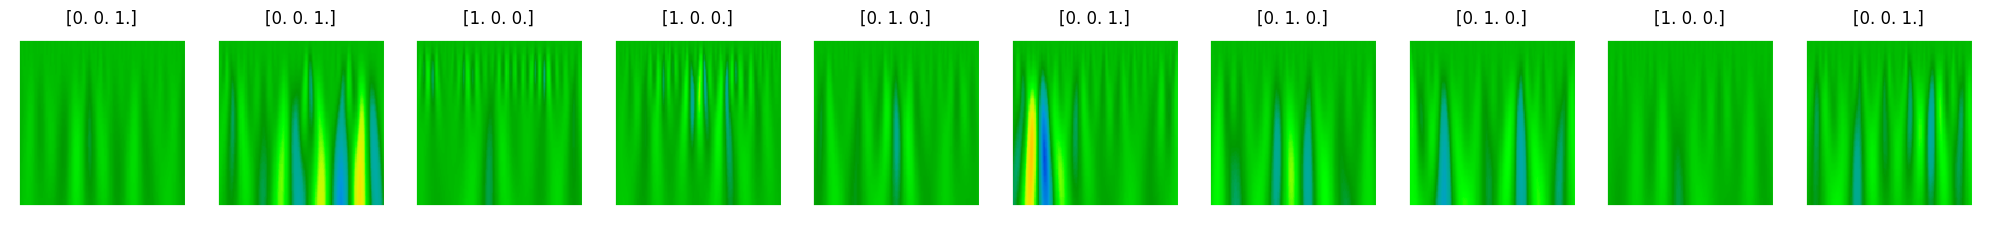

2024-08-12 04:45:48.826281: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-12 04:45:48.826430: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-12 04:45:48.826488: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

2024-08-12 04:46:04.150052: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inefficientnetb1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-12 04:46:06.252568: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-08-12 04:46:07.153612: I external/local_xla/xla/service/service.cc:168] XLA service 0xe03a910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-12 04:46:07.153630: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-08-12 04:46:07.164107: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1723419967.237246 2374007 device_compiler.h:186] Compiled cluster usin

9595/9595 [==============================] - 1224s 125ms/step - loss: 0.8457 - accuracy: 0.6914 - val_loss: 0.4922 - val_accuracy: 0.8018
Epoch 2/30
9595/9595 [==============================] - 1130s 118ms/step - loss: 0.4851 - accuracy: 0.8119 - val_loss: 0.4225 - val_accuracy: 0.8326
Epoch 3/30
9595/9595 [==============================] - 1134s 118ms/step - loss: 0.4056 - accuracy: 0.8443 - val_loss: 0.3654 - val_accuracy: 0.8584
Epoch 4/30
9595/9595 [==============================] - 1139s 119ms/step - loss: 0.3601 - accuracy: 0.8604 - val_loss: 0.4414 - val_accuracy: 0.8195
Epoch 5/30
9595/9595 [==============================] - 1131s 118ms/step - loss: 0.3295 - accuracy: 0.8723 - val_loss: 0.3670 - val_accuracy: 0.8570
Epoch 5: early stopping


/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


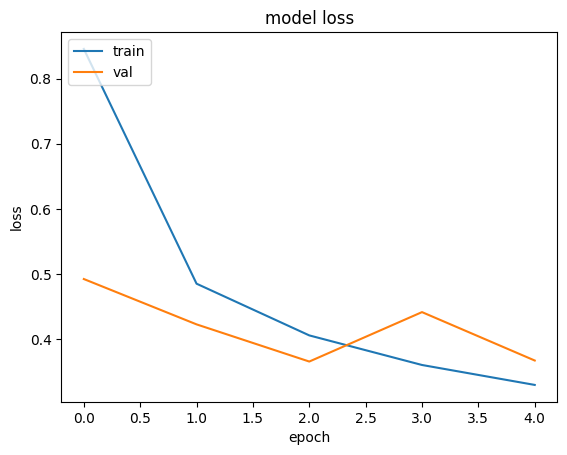

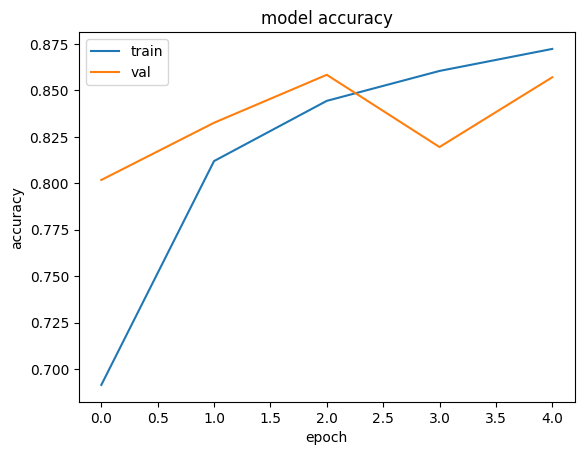

5441/5441 [==============================] - 82s 15ms/step - loss: 0.6632 - accuracy: 0.7436
5441/5441 - 75s - 75s/epoch - 14ms/step
Confusion matrix, without normalization
[[35844  3917  2111]
 [ 1162 19989  1655]
 [ 5218  8255  8898]]


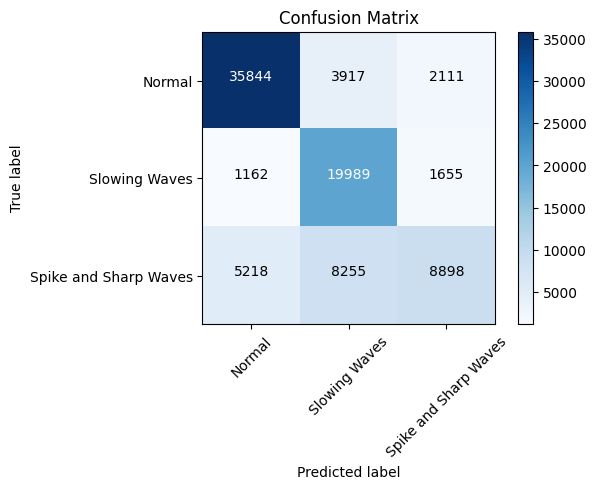

0.7436156647405484
                       precision    recall  f1-score   support

               Normal    0.84890   0.85604   0.85245     41872
        Slowing Waves    0.62153   0.87648   0.72731     22806
Spike and Sharp Waves    0.70262   0.39775   0.50795     22371

             accuracy                        0.74362     87049
            macro avg    0.72435   0.71009   0.69590     87049
         weighted avg    0.75174   0.74362   0.73113     87049

Epoch 1/30
9595/9595 [==============================] - 324s 32ms/step - loss: 1.6033 - dense_4_loss: 0.5217 - dense_1_loss: 0.5540 - dense_3_loss: 0.5276 - dense_4_accuracy: 0.7853 - dense_1_accuracy: 0.7691 - dense_3_accuracy: 0.7826 - val_loss: 1.3600 - val_dense_4_loss: 0.4491 - val_dense_1_loss: 0.4664 - val_dense_3_loss: 0.4444 - val_dense_4_accuracy: 0.8229 - val_dense_1_accuracy: 0.8157 - val_dense_3_accuracy: 0.8263
Epoch 2/30
9595/9595 [==============================] - 302s 31ms/step - loss: 1.3051 - dense_4_loss: 0.4217

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


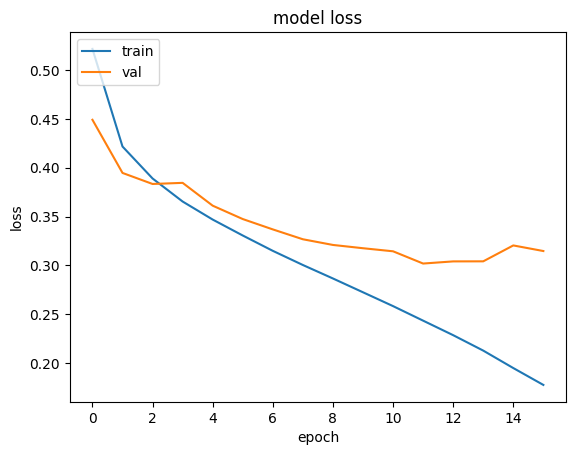

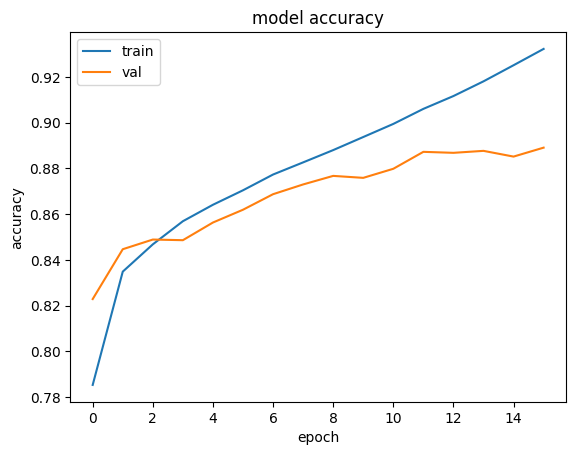

5441/5441 [==============================] - 55s 10ms/step - loss: 2.0224 - dense_4_loss: 0.7667 - dense_1_loss: 0.6017 - dense_3_loss: 0.6541 - dense_4_accuracy: 0.7684 - dense_1_accuracy: 0.7723 - dense_3_accuracy: 0.7779
5441/5441 - 54s - 54s/epoch - 10ms/step
Confusion matrix, without normalization
[[37552  2279  2041]
 [ 2009 17699  3098]
 [ 4978  5417 11976]]


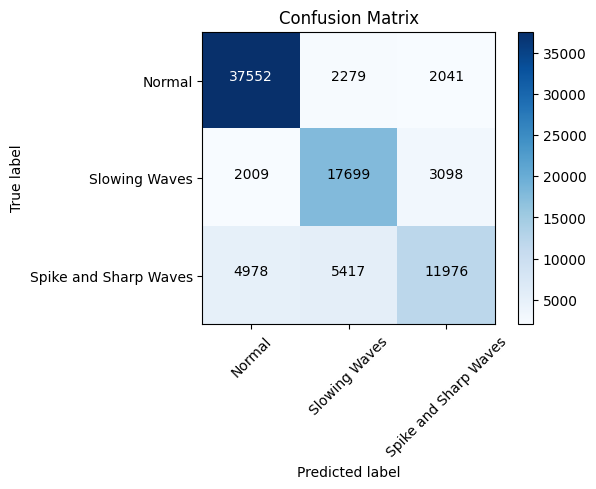

0.7722891704672081
                       precision    recall  f1-score   support

               Normal    0.84313   0.89683   0.86915     41872
        Slowing Waves    0.69695   0.77607   0.73438     22806
Spike and Sharp Waves    0.69974   0.53534   0.60659     22371

             accuracy                        0.77229     87049
            macro avg    0.74660   0.73608   0.73671     87049
         weighted avg    0.76798   0.77229   0.76637     87049

Epoch 1/30
9595/9595 [==============================] - 1121s 116ms/step - loss: 0.4520 - accuracy: 0.8217 - val_loss: 0.4196 - val_accuracy: 0.8359
Epoch 2/30
9595/9595 [==============================] - 1104s 115ms/step - loss: 0.3702 - accuracy: 0.8556 - val_loss: 0.3666 - val_accuracy: 0.8571
Epoch 3/30
9595/9595 [==============================] - 1101s 115ms/step - loss: 0.3426 - accuracy: 0.8672 - val_loss: 0.3459 - val_accuracy: 0.8639
Epoch 4/30
9595/9595 [==============================] - 1101s 115ms/step - loss: 0.3195 - 

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


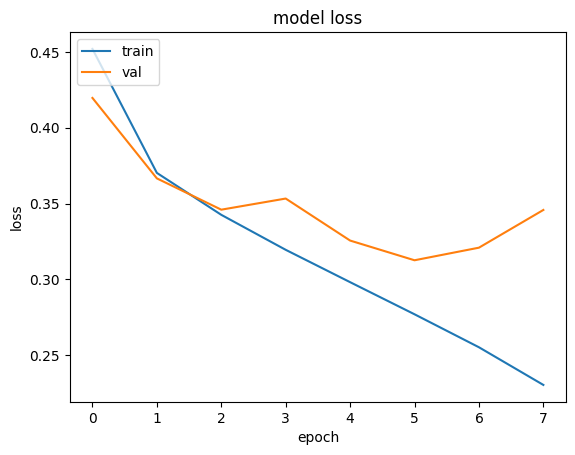

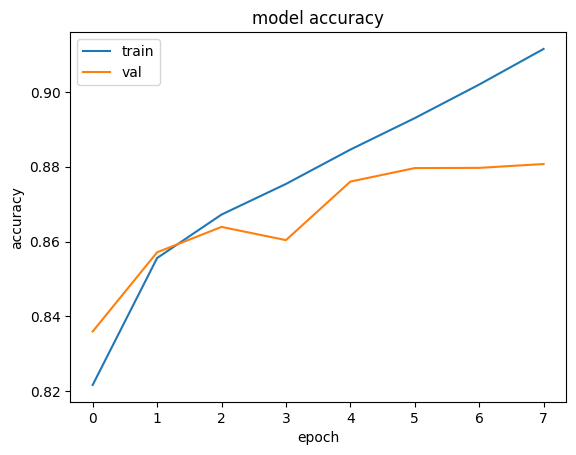

5441/5441 [==============================] - 120s 22ms/step - loss: 0.7570 - accuracy: 0.7525
5441/5441 - 113s - 113s/epoch - 21ms/step
Confusion matrix, without normalization
[[37032  2089  2751]
 [ 3386 14967  4453]
 [ 3455  5412 13504]]


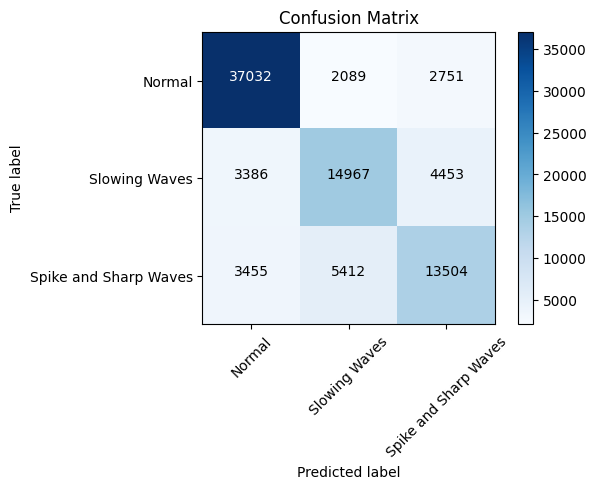

0.7524842330181851
                       precision    recall  f1-score   support

               Normal    0.84407   0.88441   0.86377     41872
        Slowing Waves    0.66615   0.65627   0.66117     22806
Spike and Sharp Waves    0.65212   0.60364   0.62694     22371

             accuracy                        0.75248     87049
            macro avg    0.72078   0.71477   0.71730     87049
         weighted avg    0.74813   0.75248   0.74983     87049

------------------- morl -------------------------
Found 307067 images belonging to 3 classes.
Found 53423 images belonging to 3 classes.
Found 87081 images belonging to 3 classes.
Class Weights {0: 0.6868724150041047, 1: 1.077825163656786, 2: 1.6225040289556418}


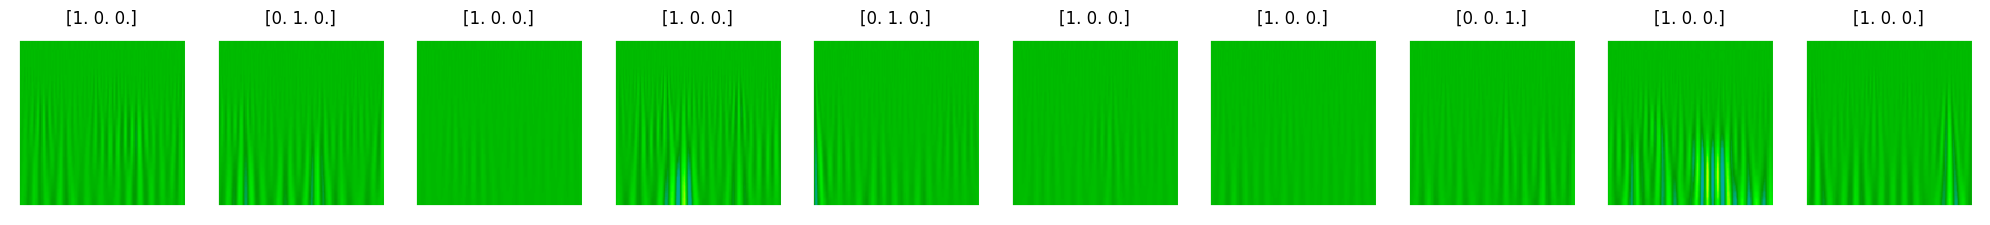

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

2024-08-12 10:18:53.175370: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inefficientnetb1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


9596/9596 [==============================] - 1153s 118ms/step - loss: 0.9271 - accuracy: 0.6262 - val_loss: 0.8818 - val_accuracy: 0.6515
Epoch 2/30
9596/9596 [==============================] - 1131s 118ms/step - loss: 0.6115 - accuracy: 0.7488 - val_loss: 0.5002 - val_accuracy: 0.7987
Epoch 3/30
9596/9596 [==============================] - 1131s 118ms/step - loss: 0.4982 - accuracy: 0.8000 - val_loss: 0.5292 - val_accuracy: 0.7945
Epoch 4/30
9596/9596 [==============================] - 1255s 131ms/step - loss: 0.4380 - accuracy: 0.8251 - val_loss: 0.4094 - val_accuracy: 0.8358
Epoch 5/30
9596/9596 [==============================] - 1184s 123ms/step - loss: 0.3973 - accuracy: 0.8429 - val_loss: 0.3790 - val_accuracy: 0.8529
Epoch 6/30
9596/9596 [==============================] - 1141s 119ms/step - loss: 0.3659 - accuracy: 0.8563 - val_loss: 0.3729 - val_accuracy: 0.8536
Epoch 7/30
9596/9596 [==============================] - 1140s 119ms/step - loss: 0.3380 - accuracy: 0.8678 - val_loss

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


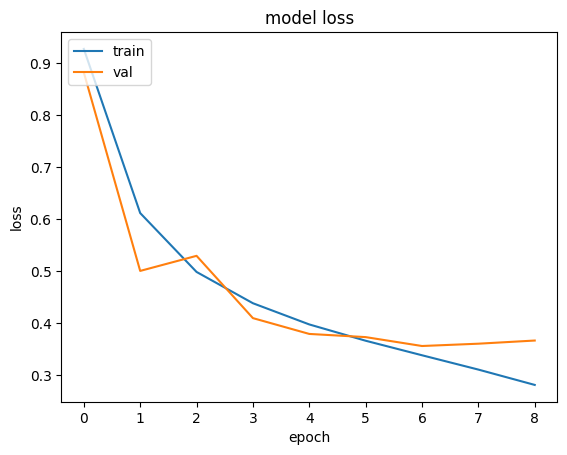

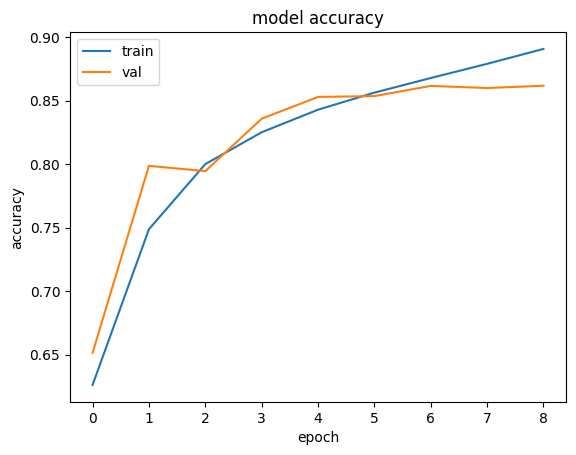

5443/5443 [==============================] - 84s 15ms/step - loss: 0.9152 - accuracy: 0.6814
5443/5443 - 76s - 76s/epoch - 14ms/step
Confusion matrix, without normalization
[[36428  3224  2252]
 [ 3532 13358  5916]
 [ 4412  8410  9549]]


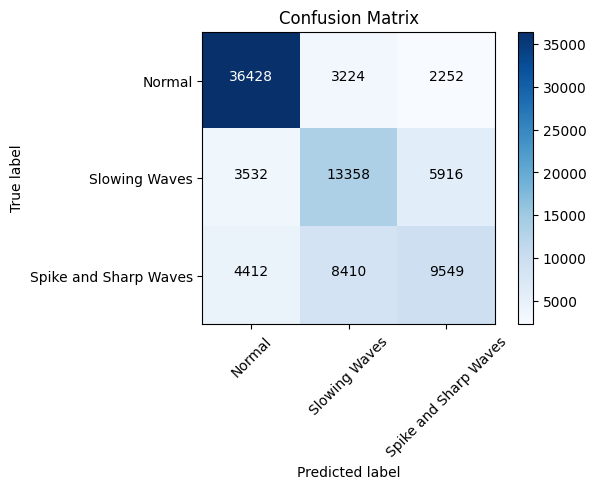

0.6813771086689404
                       precision    recall  f1-score   support

               Normal    0.82097   0.86932   0.84445     41904
        Slowing Waves    0.53449   0.58572   0.55894     22806
Spike and Sharp Waves    0.53897   0.42685   0.47640     22371

             accuracy                        0.68138     87081
            macro avg    0.63148   0.62730   0.62660     87081
         weighted avg    0.67350   0.68138   0.67513     87081

Epoch 1/30
9596/9596 [==============================] - 320s 33ms/step - loss: 1.8478 - dense_4_loss: 0.6034 - dense_1_loss: 0.6374 - dense_3_loss: 0.6070 - dense_4_accuracy: 0.7437 - dense_1_accuracy: 0.7268 - dense_3_accuracy: 0.7425 - val_loss: 1.5651 - val_dense_4_loss: 0.5174 - val_dense_1_loss: 0.5313 - val_dense_3_loss: 0.5164 - val_dense_4_accuracy: 0.7894 - val_dense_1_accuracy: 0.7834 - val_dense_3_accuracy: 0.7901
Epoch 2/30
9596/9596 [==============================] - 305s 32ms/step - loss: 1.4832 - dense_4_loss: 0.4817

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


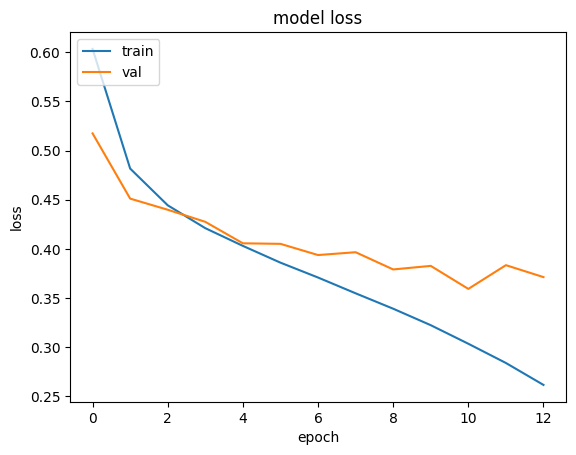

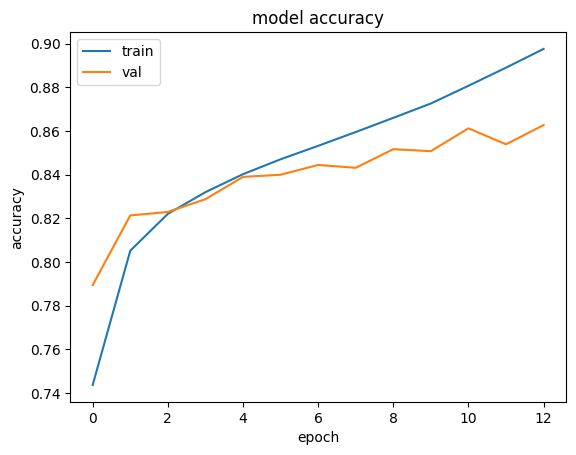

5443/5443 [==============================] - 57s 10ms/step - loss: 2.9018 - dense_4_loss: 1.0682 - dense_1_loss: 0.8453 - dense_3_loss: 0.9883 - dense_4_accuracy: 0.6680 - dense_1_accuracy: 0.6820 - dense_3_accuracy: 0.6727
5443/5443 - 55s - 55s/epoch - 10ms/step
Confusion matrix, without normalization
[[37286  2876  1742]
 [ 3815 12446  6545]
 [ 5681  7036  9654]]


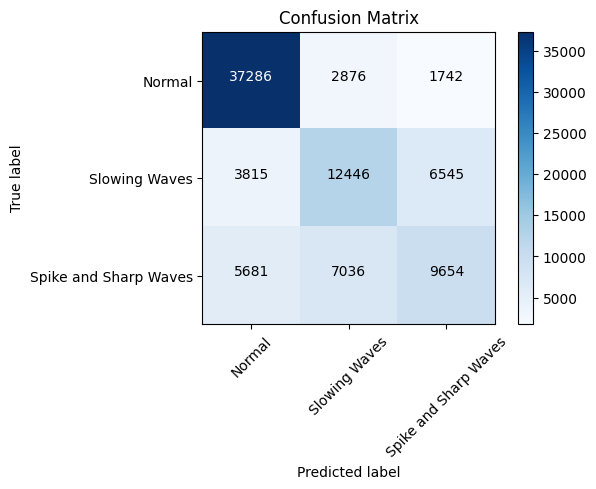

0.6819627702943237
                       precision    recall  f1-score   support

               Normal    0.79702   0.88980   0.84085     41904
        Slowing Waves    0.55667   0.54573   0.55115     22806
Spike and Sharp Waves    0.53810   0.43154   0.47896     22371

             accuracy                        0.68196     87081
            macro avg    0.63059   0.62236   0.62366     87081
         weighted avg    0.66755   0.68196   0.67201     87081

Epoch 1/30
9596/9596 [==============================] - 1120s 117ms/step - loss: 0.5489 - accuracy: 0.7717 - val_loss: 0.4476 - val_accuracy: 0.8193
Epoch 2/30
9596/9596 [==============================] - 1104s 115ms/step - loss: 0.4309 - accuracy: 0.8283 - val_loss: 0.4166 - val_accuracy: 0.8357
Epoch 3/30
9596/9596 [==============================] - 1105s 115ms/step - loss: 0.3947 - accuracy: 0.8436 - val_loss: 0.3907 - val_accuracy: 0.8468
Epoch 4/30
9596/9596 [==============================] - 1100s 115ms/step - loss: 0.3425 - 

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


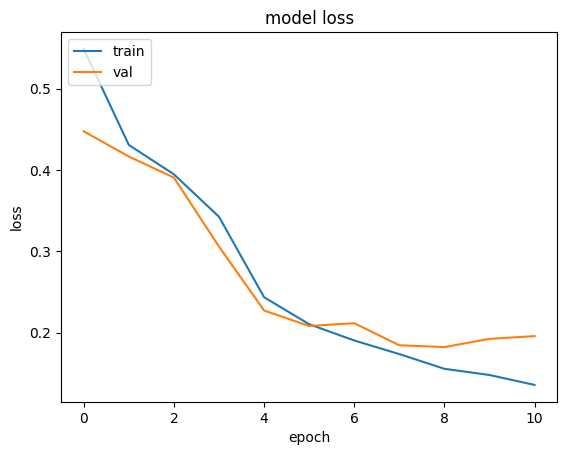

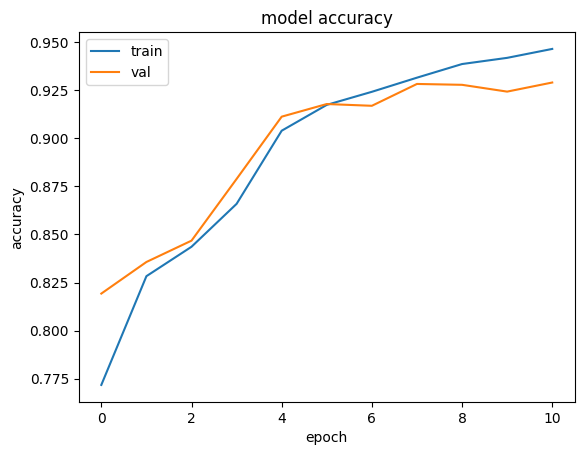

5443/5443 [==============================] - 219s 40ms/step - loss: 0.5144 - accuracy: 0.8135
5443/5443 - 186s - 186s/epoch - 34ms/step
Confusion matrix, without normalization
[[40729   676   499]
 [  209 18602  3995]
 [ 1831  9033 11507]]


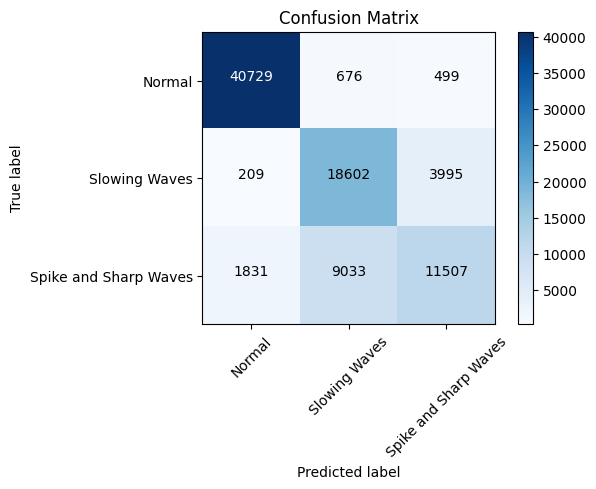

0.8134725140960715
                       precision    recall  f1-score   support

               Normal    0.95230   0.97196   0.96203     41904
        Slowing Waves    0.65706   0.81566   0.72782     22806
Spike and Sharp Waves    0.71914   0.51437   0.59976     22371

             accuracy                        0.81347     87081
            macro avg    0.77617   0.76733   0.76320     87081
         weighted avg    0.81508   0.81347   0.80763     87081

------------------- gaus1 -------------------------
Found 307075 images belonging to 3 classes.
Found 53430 images belonging to 3 classes.
Found 87059 images belonging to 3 classes.
Class Weights {0: 0.6868534362243471, 1: 1.0778532441776796, 2: 1.6225462999656548}


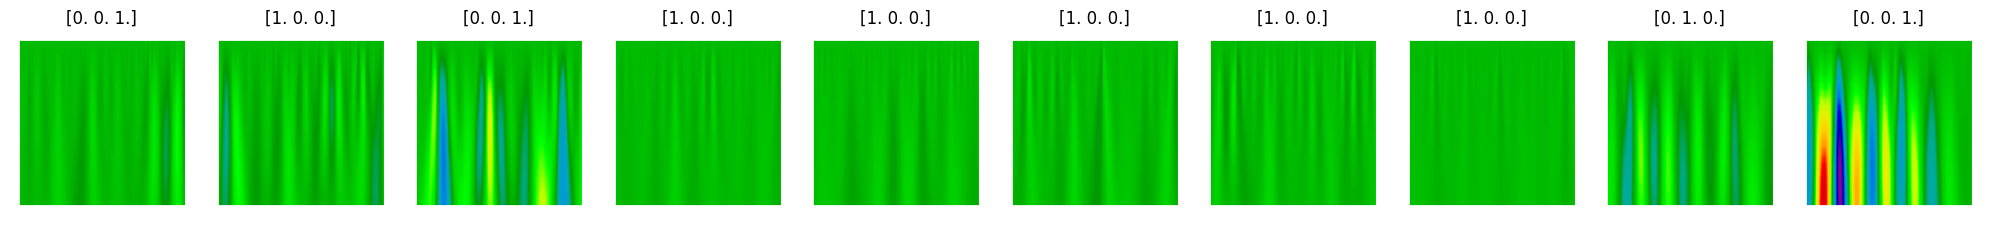

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

2024-08-12 18:09:30.559455: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inefficientnetb1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


9597/9597 [==============================] - 1626s 162ms/step - loss: 0.8687 - accuracy: 0.6821 - val_loss: 0.6853 - val_accuracy: 0.7511
Epoch 2/30
9597/9597 [==============================] - 1502s 157ms/step - loss: 0.4953 - accuracy: 0.8074 - val_loss: 0.4456 - val_accuracy: 0.8247
Epoch 3/30
9597/9597 [==============================] - 1344s 140ms/step - loss: 0.4086 - accuracy: 0.8424 - val_loss: 0.3651 - val_accuracy: 0.8584
Epoch 4/30
9597/9597 [==============================] - 1140s 119ms/step - loss: 0.3611 - accuracy: 0.8602 - val_loss: 0.5023 - val_accuracy: 0.7952
Epoch 5/30
9597/9597 [==============================] - 1141s 119ms/step - loss: 0.3275 - accuracy: 0.8731 - val_loss: 0.3249 - val_accuracy: 0.8749
Epoch 6/30
9597/9597 [==============================] - 1141s 119ms/step - loss: 0.3031 - accuracy: 0.8827 - val_loss: 0.3028 - val_accuracy: 0.8826
Epoch 7/30
9597/9597 [==============================] - 1140s 119ms/step - loss: 0.2773 - accuracy: 0.8933 - val_loss

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


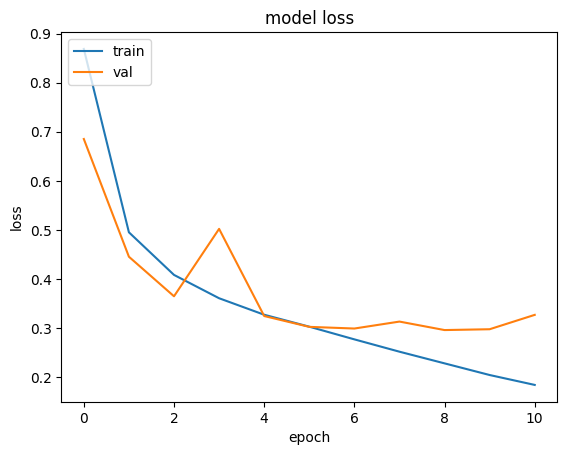

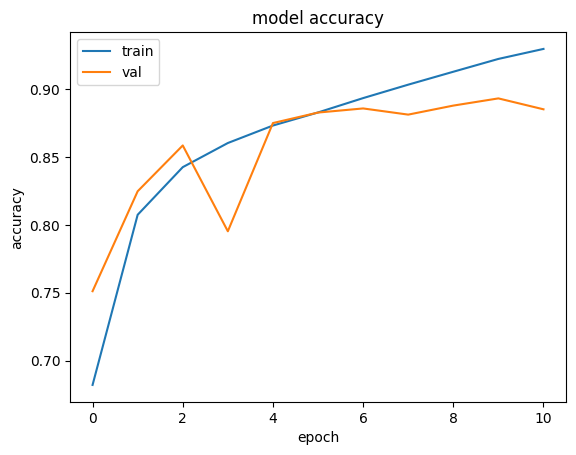

5442/5442 [==============================] - 83s 15ms/step - loss: 0.7703 - accuracy: 0.7581
5442/5442 - 76s - 76s/epoch - 14ms/step
Confusion matrix, without normalization
[[36021  2992  2869]
 [ 1557 17645  3604]
 [ 3687  6351 12333]]


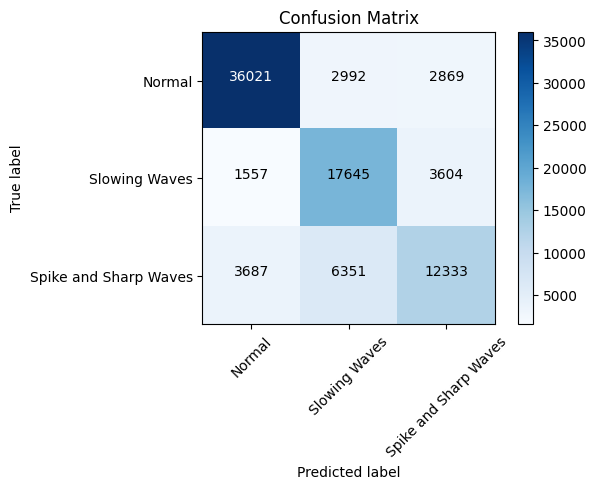

0.7580950849423954
                       precision    recall  f1-score   support

               Normal    0.87292   0.86006   0.86644     41882
        Slowing Waves    0.65381   0.77370   0.70872     22806
Spike and Sharp Waves    0.65580   0.55129   0.59902     22371

             accuracy                        0.75810     87059
            macro avg    0.72751   0.72835   0.72473     87059
         weighted avg    0.75973   0.75810   0.75641     87059

Epoch 1/30
9597/9597 [==============================] - 319s 32ms/step - loss: 1.6443 - dense_4_loss: 0.5347 - dense_1_loss: 0.5682 - dense_3_loss: 0.5414 - dense_4_accuracy: 0.7789 - dense_1_accuracy: 0.7606 - dense_3_accuracy: 0.7747 - val_loss: 1.3888 - val_dense_4_loss: 0.4532 - val_dense_1_loss: 0.4812 - val_dense_3_loss: 0.4544 - val_dense_4_accuracy: 0.8201 - val_dense_1_accuracy: 0.8066 - val_dense_3_accuracy: 0.8185
Epoch 2/30
9597/9597 [==============================] - 305s 32ms/step - loss: 1.3189 - dense_4_loss: 0.4259

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


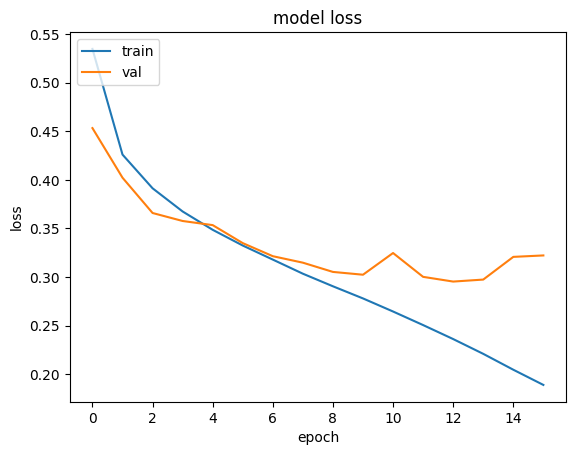

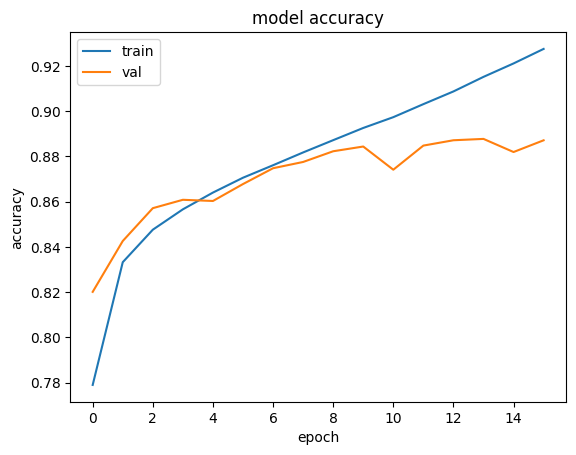

5442/5442 [==============================] - 54s 10ms/step - loss: 2.0531 - dense_4_loss: 0.8069 - dense_1_loss: 0.5537 - dense_3_loss: 0.6924 - dense_4_accuracy: 0.7545 - dense_1_accuracy: 0.7883 - dense_3_accuracy: 0.7665
5442/5442 - 52s - 52s/epoch - 10ms/step
Confusion matrix, without normalization
[[37939  2262  1681]
 [ 1487 18125  3194]
 [ 4472  5338 12561]]


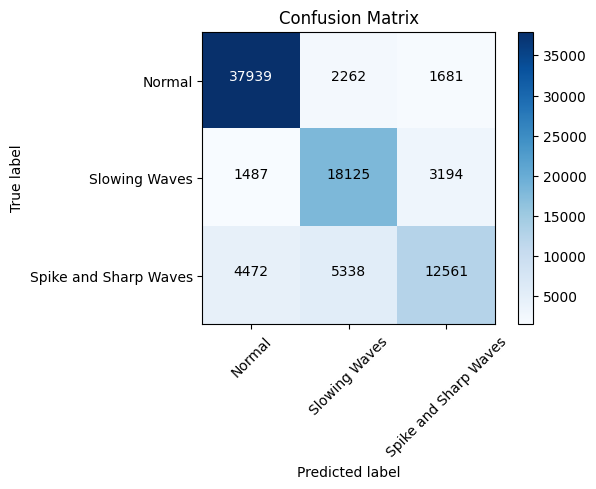

0.7882585373137757
                       precision    recall  f1-score   support

               Normal    0.86425   0.90585   0.88457     41882
        Slowing Waves    0.70457   0.79475   0.74695     22806
Spike and Sharp Waves    0.72041   0.56149   0.63110     22371

             accuracy                        0.78826     87059
            macro avg    0.76308   0.75403   0.75420     87059
         weighted avg    0.78546   0.78826   0.78338     87059

Epoch 1/30
9597/9597 [==============================] - 1119s 116ms/step - loss: 0.4552 - accuracy: 0.8203 - val_loss: 0.3860 - val_accuracy: 0.8467
Epoch 2/30
9597/9597 [==============================] - 1109s 116ms/step - loss: 0.3701 - accuracy: 0.8559 - val_loss: 0.3620 - val_accuracy: 0.8594
Epoch 3/30
9597/9597 [==============================] - 1108s 115ms/step - loss: 0.3393 - accuracy: 0.8685 - val_loss: 0.3255 - val_accuracy: 0.8747
Epoch 4/30
9597/9597 [==============================] - 1108s 115ms/step - loss: 0.3161 - 

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


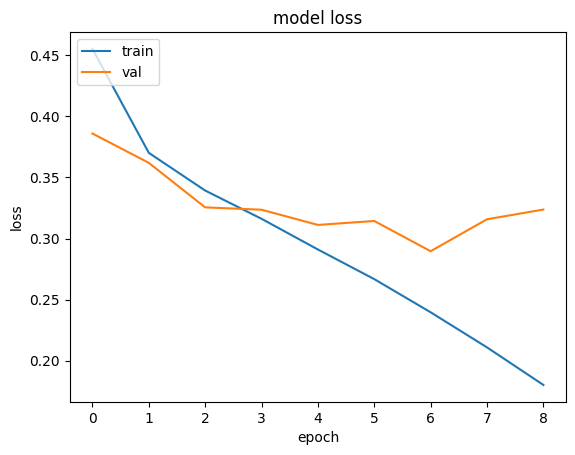

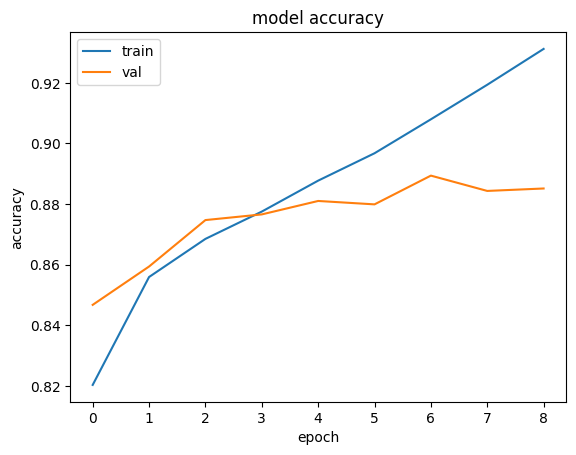

5442/5442 [==============================] - 122s 22ms/step - loss: 0.8156 - accuracy: 0.7419
5442/5442 - 114s - 114s/epoch - 21ms/step
Confusion matrix, without normalization
[[36230  2791  2861]
 [ 2404 16602  3800]
 [ 3820  6794 11757]]


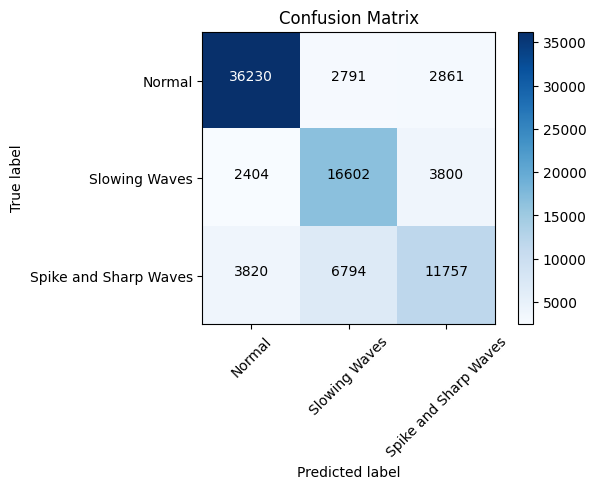

0.7418991718260031
                       precision    recall  f1-score   support

               Normal    0.85339   0.86505   0.85918     41882
        Slowing Waves    0.63398   0.72797   0.67773     22806
Spike and Sharp Waves    0.63834   0.52555   0.57648     22371

             accuracy                        0.74190     87059
            macro avg    0.70857   0.70619   0.70446     87059
         weighted avg    0.74066   0.74190   0.73900     87059

------------------- gaus2 -------------------------
Found 307032 images belonging to 3 classes.
Found 53413 images belonging to 3 classes.
Found 87064 images belonging to 3 classes.
Class Weights {0: 0.6869554711307406, 1: 1.077702311377876, 2: 1.6223190932868352}


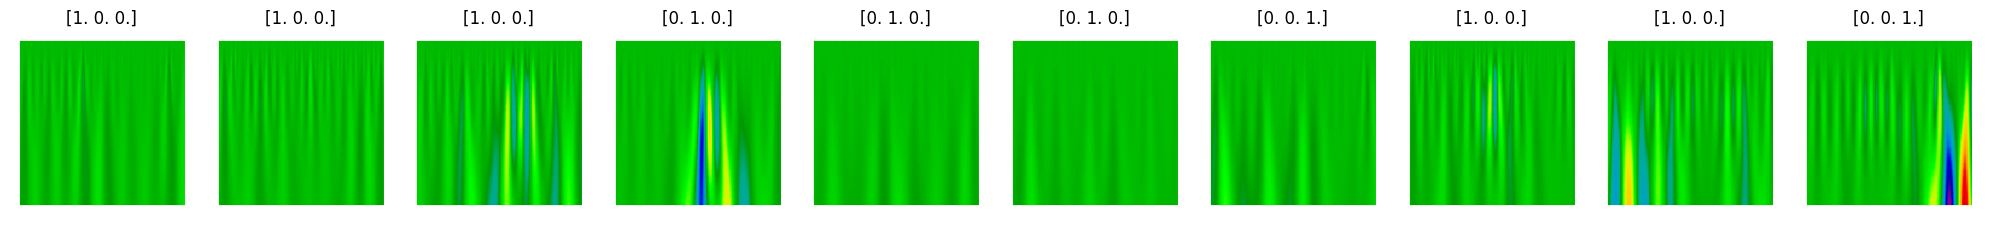

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

2024-08-13 02:12:54.584129: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inefficientnetb1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


9595/9595 [==============================] - 1171s 120ms/step - loss: 0.8028 - accuracy: 0.7012 - val_loss: 0.5256 - val_accuracy: 0.7914
Epoch 2/30
9595/9595 [==============================] - 1143s 119ms/step - loss: 0.4915 - accuracy: 0.8100 - val_loss: 0.4885 - val_accuracy: 0.8093
Epoch 3/30
9595/9595 [==============================] - 1145s 119ms/step - loss: 0.4181 - accuracy: 0.8389 - val_loss: 0.4159 - val_accuracy: 0.8381
Epoch 4/30
9595/9595 [==============================] - 1144s 119ms/step - loss: 0.3723 - accuracy: 0.8566 - val_loss: 0.3469 - val_accuracy: 0.8641
Epoch 5/30
9595/9595 [==============================] - 1143s 119ms/step - loss: 0.3382 - accuracy: 0.8688 - val_loss: 0.3917 - val_accuracy: 0.8486
Epoch 6/30
9595/9595 [==============================] - 1143s 119ms/step - loss: 0.3111 - accuracy: 0.8789 - val_loss: 0.3356 - val_accuracy: 0.8683
Epoch 7/30
9595/9595 [==============================] - 1143s 119ms/step - loss: 0.2867 - accuracy: 0.8892 - val_loss

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


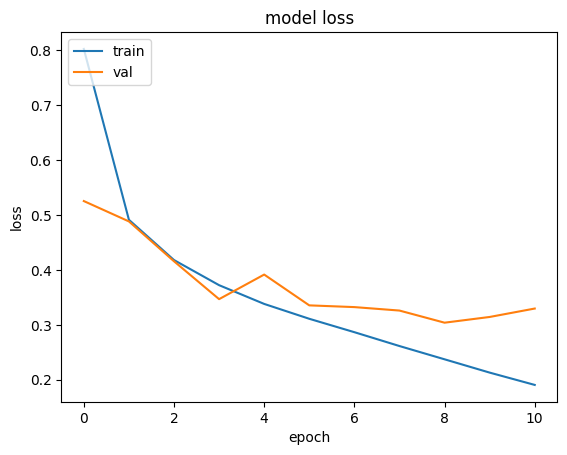

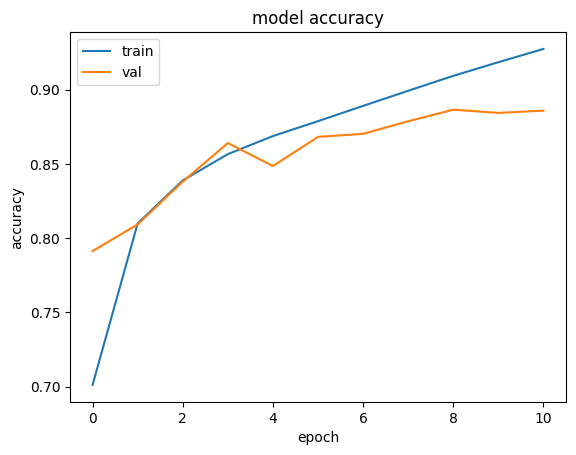

5442/5442 [==============================] - 87s 16ms/step - loss: 0.7655 - accuracy: 0.7611
5442/5442 - 76s - 76s/epoch - 14ms/step
Confusion matrix, without normalization
[[37141  2481  2265]
 [ 2201 16981  3624]
 [ 5222  5009 12140]]


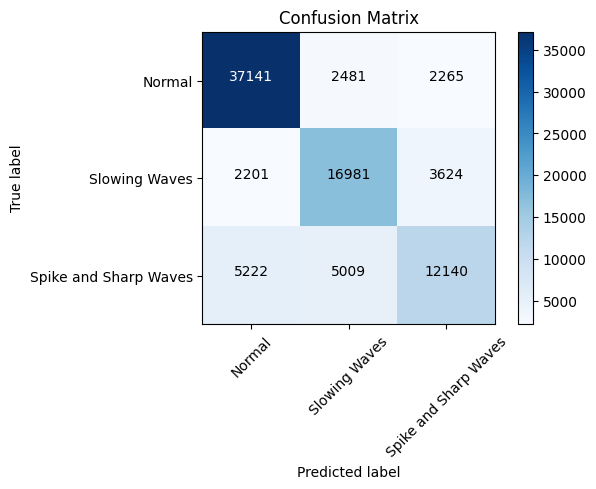

0.7610723146191307
                       precision    recall  f1-score   support

               Normal    0.83343   0.88670   0.85924     41887
        Slowing Waves    0.69392   0.74458   0.71836     22806
Spike and Sharp Waves    0.67336   0.54267   0.60099     22371

             accuracy                        0.76107     87064
            macro avg    0.73357   0.72465   0.72620     87064
         weighted avg    0.75576   0.76107   0.75598     87064

Epoch 1/30
9595/9595 [==============================] - 318s 32ms/step - loss: 1.6296 - dense_4_loss: 0.5290 - dense_1_loss: 0.5666 - dense_3_loss: 0.5341 - dense_4_accuracy: 0.7817 - dense_1_accuracy: 0.7610 - dense_3_accuracy: 0.7793 - val_loss: 1.3370 - val_dense_4_loss: 0.4332 - val_dense_1_loss: 0.4683 - val_dense_3_loss: 0.4355 - val_dense_4_accuracy: 0.8291 - val_dense_1_accuracy: 0.8135 - val_dense_3_accuracy: 0.8287
Epoch 2/30
9595/9595 [==============================] - 306s 32ms/step - loss: 1.3181 - dense_4_loss: 0.4260

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


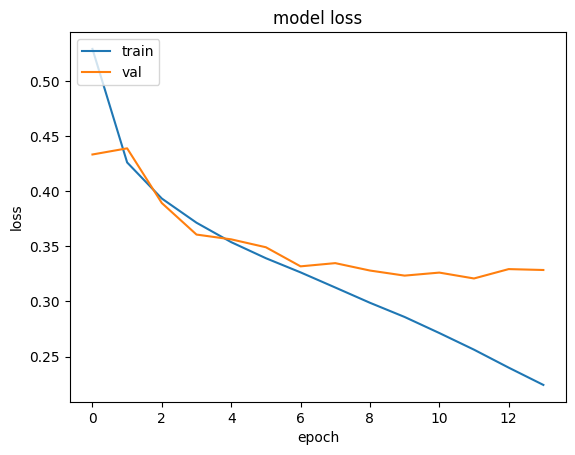

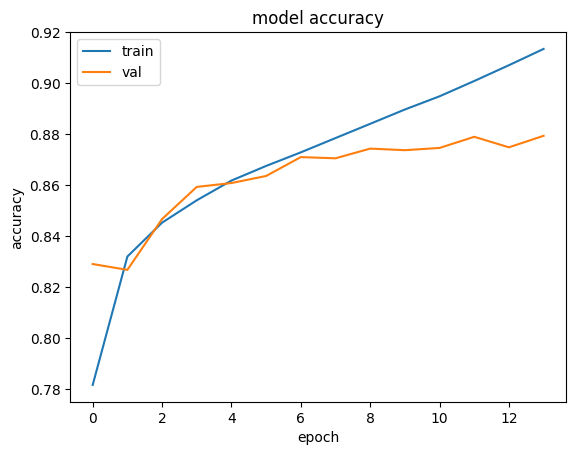

5442/5442 [==============================] - 55s 10ms/step - loss: 2.0368 - dense_4_loss: 0.7270 - dense_1_loss: 0.6284 - dense_3_loss: 0.6815 - dense_4_accuracy: 0.7494 - dense_1_accuracy: 0.7639 - dense_3_accuracy: 0.7550
5442/5442 - 53s - 53s/epoch - 10ms/step
Confusion matrix, without normalization
[[37855  2251  1781]
 [ 2377 16729  3700]
 [ 5900  4543 11928]]


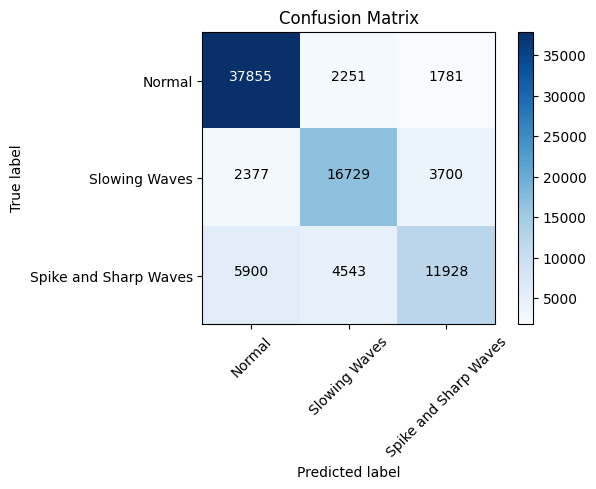

0.7639437655058348
                       precision    recall  f1-score   support

               Normal    0.82058   0.90374   0.86016     41887
        Slowing Waves    0.71118   0.73354   0.72218     22806
Spike and Sharp Waves    0.68516   0.53319   0.59970     22371

             accuracy                        0.76394     87064
            macro avg    0.73897   0.72349   0.72735     87064
         weighted avg    0.75713   0.76394   0.75709     87064

Epoch 1/30
9595/9595 [==============================] - 1123s 117ms/step - loss: 0.4691 - accuracy: 0.8120 - val_loss: 0.4108 - val_accuracy: 0.8391
Epoch 2/30
9595/9595 [==============================] - 1111s 116ms/step - loss: 0.3809 - accuracy: 0.8511 - val_loss: 0.3778 - val_accuracy: 0.8530
Epoch 3/30
9595/9595 [==============================] - 1109s 116ms/step - loss: 0.3504 - accuracy: 0.8638 - val_loss: 0.3538 - val_accuracy: 0.8636
Epoch 4/30
9595/9595 [==============================] - 1108s 115ms/step - loss: 0.3298 - 

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


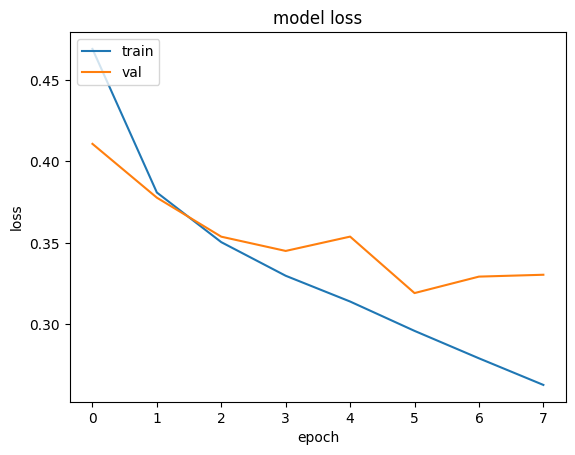

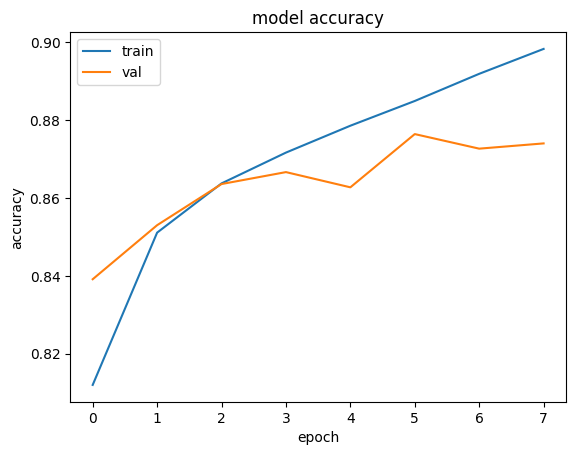

5442/5442 [==============================] - 122s 22ms/step - loss: 0.7633 - accuracy: 0.7271
5442/5442 - 114s - 114s/epoch - 21ms/step
Confusion matrix, without normalization
[[37667  2478  1742]
 [ 3558 15611  3637]
 [ 6776  5571 10024]]


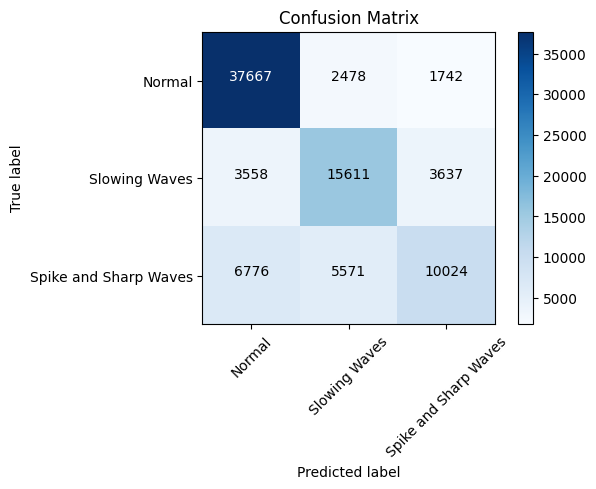

0.7270743361205549
                       precision    recall  f1-score   support

               Normal    0.78471   0.89925   0.83809     41887
        Slowing Waves    0.65981   0.68451   0.67193     22806
Spike and Sharp Waves    0.65078   0.44808   0.53074     22371

             accuracy                        0.72707     87064
            macro avg    0.69843   0.67728   0.68025     87064
         weighted avg    0.71758   0.72707   0.71559     87064



In [12]:
for waveletsType in waveletsTypes:
    
    print("-------------------",waveletsType,"-------------------------")
    checkpoint_filepath = '/home/dll-1/Desktop/eeg/datasets/models/adil/deeplearning/'+waveletsType

    train_path = main_directory +'/'+waveletsType+'/train' + '/'
    valid_path = main_directory +'/'+waveletsType+'/valid' + '/'
    test_path = main_directory +'/'+waveletsType+'/test' + '/'

    train_batches = train_datagen.flow_from_directory(directory = train_path, target_size = (224, 224),interpolation = 'nearest', classes = class_labels, batch_size = 32, shuffle = True)
    valid_batches = valid_datagen.flow_from_directory(directory = valid_path, target_size = (224, 224),interpolation = 'nearest', classes = class_labels, batch_size = 16)
    test_batches = test_datagen.flow_from_directory(directory = test_path, target_size = (224, 224), interpolation = 'nearest',classes = class_labels, batch_size = 16, shuffle = False)

    # Class Weigths
    labels = train_batches.classes
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
    class_weights = dict(enumerate(class_weights))
    print('Class Weights',class_weights)
    
    assert valid_batches.n > 0
    assert test_batches.n > 0
    assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 3

    imgs, train_labels = next(train_batches)
    plotImages(imgs,train_labels) 

    effNet_model_custom = tf.keras.applications.EfficientNetB1(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=3,classifier_activation='softmax')
    effNet_model_custom.summary()
    effNet_model_custom.compile(Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    
    effNet_model_custom = evaluate_effNet(effNet_model_custom, train_batches,valid_batches,checkpoint_filepath, class_weights)
    test_model(effNet_model_custom, test_batches,"effNet")

    ##### VGG16

    ###### Import and Build Model


    vgg16_model = keras.applications.vgg16.VGG16()

    vgg16_model_custom = Sequential()
    for layer in vgg16_model.layers[:-1]:
        vgg16_model_custom.add(layer)

    # for layer in model.layers:
    #     layer.trainable = False

    vgg16_model_custom.add(Dense(3, activation = 'softmax'))

    vgg16_model_custom.summary()
    vgg16_model_custom.compile(Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    vgg16_model_custom = evaluate_vgg16(vgg16_model_custom, train_batches,valid_batches,checkpoint_filepath, class_weights)
    test_model(vgg16_model_custom, test_batches,"vgg16")


    google_lenet = GoogLeNet()

    # google_lenet.summary()
    google_lenet.compile(optimizer = Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics = ['accuracy'])    

    google_lenet_model = evaluate_googlenet(google_lenet, train_batches,valid_batches,checkpoint_filepath,class_weights)
    test_model(google_lenet,test_batches,"googlenet")


    

    

    


    

[0.012355835328567067, 0.044887513730311336, 0.027276363393971687]
[0.693, 0.7323333333333334, 0.777]


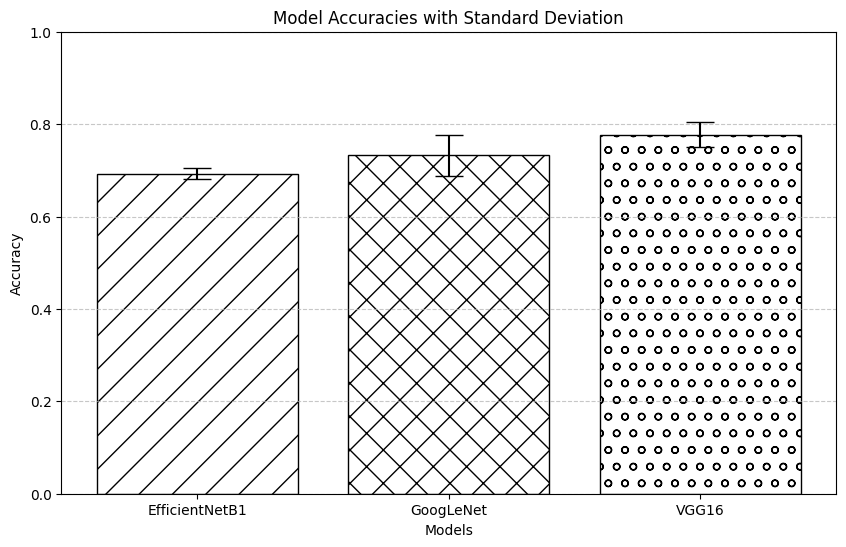

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Example data: multiple accuracy values for each model (simulating different runs)
model_1_accuracies = [0.710, 0.688, 0.681]
model_2_accuracies = [0.724, 0.791, 0.682]
model_3_accuracies = [0.747, 0.771, 0.813]

# model_1_accuracies = [0.688, 0.681]
# model_2_accuracies = [0.791, 0.682]
# model_3_accuracies = [0.771, 0.813]

# Calculate mean and standard deviation for each model
models = ['EfficientNetB1', 'GoogLeNet', 'VGG16']
accuracies = [
    np.mean(model_1_accuracies),
    np.mean(model_2_accuracies),
    np.mean(model_3_accuracies)
]
std_devs = [
    np.std(model_1_accuracies),
    np.std(model_2_accuracies),
    np.std(model_3_accuracies)
]
print(std_devs)
print(accuracies)
"EffecientNet"
# Plotting
# Define hatch patterns for each bar
hatch_patterns = ['/', 'x', 'o']

plt.figure(figsize=(10, 6))

# Create the bar plot with different hatch patterns
bars = plt.bar(models, accuracies, yerr=std_devs, capsize=10, color='white', edgecolor='black')

# Apply hatch patterns
for bar, hatch in zip(bars, hatch_patterns):
    bar.set_hatch(hatch)

plt.title('Model Accuracies with Standard Deviation')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

